In [1]:
# Essential packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import math
import pickle

# Text cleaning packages
import nltk 
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Text feature packages
import textstat
from lexical_diversity import lex_div as ld
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word embedding
import gensim
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import TruncatedSVD

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Model explanation
import shap

In [2]:
df = pd.read_csv('data/model_data.csv')
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL


# Data Cleaning

In [3]:
def lem_words(text):
    text = text.split()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    return text

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [4]:
df['full_document'] = df['blurb'] + ' ' + df['story'] 
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state,full_document
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin,"4tec is a classic 4 in a row table top game, r..."
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC,Our aim is to bridge the communication barrier...
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA,Creating more positive opportunities (job pla...
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England,NOT WATTS will be the first 100% sustainable r...
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW,Sydney's 1st cloud kitchen that delivers fresh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA,HipStick - The training tool that focuses on c...
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin,We reconnect professionals in the real world a...
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL,The 1st turnkey sports mgmt & analytics applic...
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL,"Vibration app, that helps you find friends, ve..."


In [5]:
df['full_document'] = df.full_document.apply(func=make_lower_case)
df['full_document'] = df.full_document.apply(func=remove_stop_words)
df['full_document'] = df.full_document.apply(func=remove_punctuation)
df['full_document'] = df.full_document.apply(func=lem_words)
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state,full_document
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin,4tec classic 4 row table top game redesigned n...
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC,aim bridge communication barrier currently exi...
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA,creating positive opportunity job placement cu...
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England,watt first 100 sustainable restaurant run with...
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW,sydney s 1st cloud kitchen delivers fresh deli...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA,hipstick training tool focus creating consiste...
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin,reconnect professional real world spark conver...
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL,1st turnkey sport mgmt analytics application l...
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL,vibration app help find friend vehicle locatio...


In [6]:
# Print out one cleaned text to check
df.full_document[0]

'4tec classic 4 row table top game redesigned now 4tec classic 4 row table top game redesigned now win game need get 4 counter row direction horizontal level vertically 4 level game simple set up take second learn billion combination get 4 in a row 4tec invented me john dunne 40 year ago highly unpredictable thing called life got way took till get point dream making selling 4tec world within striking distance original 4tec 1975 hand made 20 000 4tec game sold year mass production game could achieved getting entire game moulded plastic ring fenced revenue direct cost hand made game towards funding tooling plastic moulded flat pack version 4tec mark 2 2001 4tec 2001 counter box first tool got 4tec counter tool 16 cavity tool meaning cycle tool produce 16 counter game 32 red 32 yellow counter great help selling hand made game able 4tec logo moulded side counter much better plain counter purchasing then i also able design counter unique manner minimum possible contact occurs shelf counter 

# New feature creation

## Location transform

In [7]:
df.location_country.value_counts().head(20)

US    6051
GB    1256
CA     503
MX     251
DE     225
AU     221
IT     204
FR     182
ES     153
HK     125
NL      95
SE      82
SG      80
DK      59
JP      55
CH      46
NZ      42
IE      39
BE      38
AT      34
Name: location_country, dtype: int64

In [8]:
def top_ten(location):
    top_ten = ['US','GB','CA','MX','DE','AU','IT','FR','ES','HK']
    
    if location in top_ten:
        return 1
    else:
        return 0

In [9]:
df['top_ten'] = df.location_country.apply(func=top_ten)
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state,full_document,top_ten
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin,4tec classic 4 row table top game redesigned n...,0
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC,aim bridge communication barrier currently exi...,1
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA,creating positive opportunity job placement cu...,1
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England,watt first 100 sustainable restaurant run with...,1
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW,sydney s 1st cloud kitchen delivers fresh deli...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA,hipstick training tool focus creating consiste...,1
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin,reconnect professional real world spark conver...,1
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL,1st turnkey sport mgmt analytics application l...,1
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL,vibration app help find friend vehicle locatio...,1


## General text feature

In [10]:
def length(text):
    return len(text)

In [11]:
df['length'] = df.full_document.apply(func=length)
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state,full_document,top_ten,length
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin,4tec classic 4 row table top game redesigned n...,0,2065
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC,aim bridge communication barrier currently exi...,1,711
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA,creating positive opportunity job placement cu...,1,1342
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England,watt first 100 sustainable restaurant run with...,1,949
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW,sydney s 1st cloud kitchen delivers fresh deli...,1,1060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA,hipstick training tool focus creating consiste...,1,763
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin,reconnect professional real world spark conver...,1,3987
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL,1st turnkey sport mgmt analytics application l...,1,12767
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL,vibration app help find friend vehicle locatio...,1,431


## Lexical richness

In [12]:
def lex_div(text):
    token = ld.tokenize(text)
    return ld.ttr(token)

def lex_entropy(text, base = 2.0):
    #make set with all unrepeatable symbols from text
    dct = dict.fromkeys(list(text))

    #calculate frequencies
    pkvec = [float(text.count(c)) / len(text) for c in dct]

    #calculate Entropy
    H = -sum([pk * math.log(pk) / math.log(base) for pk in pkvec])
    return H

In [13]:
df['lex_diversity'] = df.full_document.apply(func=lex_div)
df['lex_entropy'] = df.full_document.apply(func=lex_entropy)
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,location_country,location_state,full_document,top_ten,length,lex_diversity,lex_entropy
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,IE,Dublin,4tec classic 4 row table top game redesigned n...,0,2065,0.595870,4.273365
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,CA,BC,aim bridge communication barrier currently exi...,1,711,0.763441,4.247977
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,US,GA,creating positive opportunity job placement cu...,1,1342,0.711957,4.218493
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,GB,England,watt first 100 sustainable restaurant run with...,1,949,0.765152,4.194116
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,AU,NSW,sydney s 1st cloud kitchen delivers fresh deli...,1,1060,0.779310,4.238193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,US,CA,hipstick training tool focus creating consiste...,1,763,0.775701,4.227916
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,DE,Berlin,reconnect professional real world spark conver...,1,3987,0.574586,4.236645
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,US,FL,1st turnkey sport mgmt analytics application l...,1,12767,0.380795,4.201696
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,15000.00000,US,FL,vibration app help find friend vehicle locatio...,1,431,0.707692,4.145162


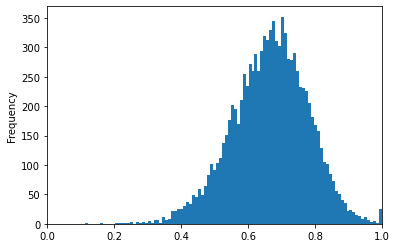

In [14]:
# Quickly check the lexical diversity and entropy distribution
df.lex_diversity.plot.hist(bins=100, xlim = [0, 1])

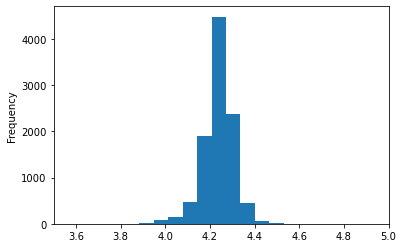

In [15]:
df.lex_entropy.plot.hist(bins=100, xlim = [3.5, 5.0])

## Lexical readability

In [16]:
def lex_readability(text, mode = 'all'):

    if mode == 'all':
        fre_score = textstat.flesch_reading_ease(text)
        fog_index = textstat.gunning_fog(text)
        fkg_index = textstat.flesch_kincaid_grade(text)
        dcr_score = textstat.dale_chall_readability_score(text)
        text_standard = textstat.text_standard(text, float_output=True)
        return fre_score, fog_index, fkg_index, dcr_score, text_standard
    
    if mode == 'fre':
        fre_score = textstat.flesch_reading_ease(text)
        return fre_score
    
    if mode == 'fog':
        fog_index = textstat.gunning_fog(text)
        return fog_index
    
    if mode == 'fkg':
        fkg_index = textstat.flesch_kincaid_grade(text)
        return fkg_index
    
    if mode == 'dcr':
        dcr_score = textstat.dale_chall_readability_score(text)
        return dcr_score
    
    if mode == 'text_std':
        text_standard = textstat.text_standard(text, float_output=True)
        return text_standard

In [17]:
df['fre_score'] = df.story.apply(func=lex_readability, args=('fre',))
df['fog_index'] = df.story.apply(func=lex_readability, args=('fog',))
df['fkg_index'] = df.story.apply(func=lex_readability, args=('fkg',))
df['dcr_score'] = df.story.apply(func=lex_readability, args=('dcr',))
df['text_standard'] = df.story.apply(func=lex_readability, args=('text_std',))
df

,id,URL,binary_state,name,blurb,story,category_slug,blurb_length,month,days_to_deadline,...,full_document,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,text_standard
0,39235,https://www.kickstarter.com/projects/39235/4te...,successful,4tec: a New 3D Connect 4 Game,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,...,4tec classic 4 row table top game redesigned n...,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,20.0
1,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Komrad - Community | Care | Comradery,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,...,aim bridge communication barrier currently exi...,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,14.0
2,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Jonesy on the Go Expansion Project,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,...,creating positive opportunity job placement cu...,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,17.0
3,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS- The restaurant that runs without el...,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,...,watt first 100 sustainable restaurant run with...,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,12.0
4,507631,https://www.kickstarter.com/projects/507631/he...,failed,"Healthy, fresh, delicious food delivered to yo...",Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,...,sydney s 1st cloud kitchen delivers fresh deli...,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - A Hitting Revolution,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,...,hipstick training tool focus creating consiste...,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,10.0
10054,1591766366,https://www.kickstarter.com/projects/159176636...,failed,HelloShrimp - The Real-Life Network for Profes...,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,...,reconnect professional real world spark conver...,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,14.0
10055,1682019474,https://www.kickstarter.com/projects/168201947...,failed,Agile Sports Analytics: Team Strategy & Player...,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,...,1st turnkey sport mgmt analytics application l...,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,12.0
10056,2028707851,https://www.kickstarter.com/projects/202870785...,failed,CrowdSurfur,"Vibration app, that helps you find friends, ve...",We are trying to complete an app that will hel...,technology,16,1,45,...,vibration app help find friend vehicle locatio...,1,431,0.707692,4.145162,76.76,10.27,7.5,6.74,8.0


In [54]:
df.to_csv('data/model_data_newVar.csv', index=False)

## Word embedding

### Doc2Vec

In [18]:
# The following code only needs to run once to generate the model output
story = df.story.values.tolist()
documents = []
for i in range(len(df)):
    mystr = story[i]
    documents.append(re.sub("[^\w]", " ",  mystr).split())

In [19]:
formatted_documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=5, epochs=200, seed=0, window=3, dm=1)
model.build_vocab(formatted_documents)

In [20]:
%time model.train(formatted_documents, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 12min 27s


In [21]:
fname = get_tmpfile("models/doc2vec_model")
model.save("models/doc2vec_model")

In [16]:
# if run more than once, the later runs could start here
model = gensim.models.doc2vec.Doc2Vec.load("./models/doc2vec_model")

In [17]:
doctovec_feature_matrix = pd.DataFrame(model.docvecs.vectors_docs, index=df.name)

In [18]:
doctovec_feature_matrix = doctovec_feature_matrix.add_prefix('d2v_')
doctovec_feature_matrix

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_90,d2v_91,d2v_92,d2v_93,d2v_94,d2v_95,d2v_96,d2v_97,d2v_98,d2v_99
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.902073,-1.621098,-0.926543,-0.442065,3.647309,3.073392,2.713694,1.409504,-1.439902,3.338297,...,-2.534779,-0.176900,3.095362,0.966774,-3.120079,-0.303085,1.169361,-0.483391,2.350688,3.707440
Komrad - Community | Care | Comradery,-0.622715,-1.302586,3.009642,-0.715653,1.878601,-0.658816,1.018946,-2.607673,2.240116,-0.871471,...,2.632383,-2.142566,0.729464,1.423505,-1.464109,-1.538552,-0.912207,-0.240881,1.298106,2.163504
Jonesy on the Go Expansion Project,1.597855,0.948570,0.732417,1.211082,-0.907459,0.507398,2.808746,-4.871488,2.520253,-3.619430,...,-0.802881,0.708144,-0.983804,1.082154,-1.694710,-1.372807,-1.860828,-1.040738,-1.956203,0.925469
NOT WATTS- The restaurant that runs without electricity.,2.089236,-1.076165,0.335656,2.080410,5.834679,-2.548035,2.564628,-3.015286,4.896177,-0.448215,...,-2.177362,-1.551219,1.309394,-0.370621,-2.392838,-1.028023,-3.046495,-1.787845,0.108494,-0.752659
"Healthy, fresh, delicious food delivered to your doorstep!",0.139801,-0.481757,0.717424,2.636825,1.717019,-2.801194,2.898628,-1.346874,4.640855,0.093653,...,0.955717,0.476158,-1.239118,-0.681135,1.607653,-3.508072,-0.247594,1.770922,0.692778,1.796560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,2.373249,-2.175169,-3.480950,-1.089958,2.257973,1.089916,2.833457,0.630982,4.996249,0.359348,...,1.217988,0.447978,2.516444,-1.691508,-2.145148,-0.367670,0.510908,-2.427168,0.960863,0.027788
HelloShrimp - The Real-Life Network for Professionals.,2.500247,-0.621047,1.809822,-1.064756,2.419722,0.480156,1.175826,-3.166432,2.639724,0.269730,...,0.248322,-1.072751,-0.274889,1.200743,-0.206908,-1.040300,0.157444,0.924319,0.523792,2.449608
Agile Sports Analytics: Team Strategy & Player Execution App,2.438273,-4.146245,-3.236355,0.201279,0.443363,2.191309,-2.176800,-0.710200,1.481071,-0.940426,...,-0.281884,-3.956750,0.768241,0.590923,-0.116503,-4.156610,0.562491,-0.118049,-1.354618,3.738206


In [21]:
# Only needs to run once to generate the model output
print(doctovec_feature_matrix.shape)
pickle.dump(doctovec_feature_matrix, open("models/doctovec_embeddings.pkl", "wb"))

(10058, 100)


### Vectorizer

In [18]:
tf = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, 2))

In [19]:
tfidf_matrix = tf.fit_transform(df['full_document']).toarray()

In [20]:
tfidf_feature_matrix = pd.DataFrame(tfidf_matrix, columns = tf.get_feature_names())
tfidf_feature_matrix.columns = ["tfidf_" + str(x) for x in tfidf_feature_matrix.columns]
tfidf_feature_matrix.index = df.name

In [21]:
print(tfidf_feature_matrix.shape)
tfidf_feature_matrix

(10058, 44799)


,tfidf_00,tfidf_00 00,tfidf_00 english,tfidf_00 kickstarter,tfidf_00 need,tfidf_00 pledge,tfidf_00 shipping,tfidf_00 want,tfidf_00 we,tfidf_000,...,tfidf_également,tfidf_él,tfidf_équipe,tfidf_été,tfidf_être,tfidf_ôøω,tfidf_ôøω äî,tfidf_ôøω äö,tfidf_ôøω ôøω,tfidf_über
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,0.100715,0.085562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Komrad - Community | Care | Comradery,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jonesy on the Go Expansion Project,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOT WATTS- The restaurant that runs without electricity.,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Healthy, fresh, delicious food delivered to your doorstep!",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HelloShrimp - The Real-Life Network for Professionals.,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agile Sports Analytics: Team Strategy & Player Execution App,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Only needs to run once to generate the model output
pickle.dump(tf, open("models/tfidf_model.pkl", "wb"))

### LSA (vectorizer+truncatedSVD)

In [26]:
n_comp = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

In [ ]:
# Only run once due to long run time
explained = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x, random_state=123)
    svd.fit(tfidf_matrix)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))

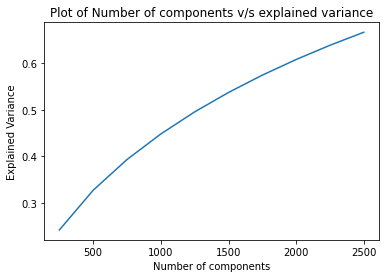

In [107]:
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [108]:
lst = [0] + explained

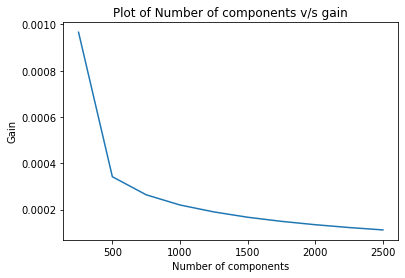

In [110]:
change_rate = []
for i in range(0,len(lst)):
    if i > 0:
        rate = (lst[i]-lst[i-1])/250
        change_rate.append(rate)
        
plt.plot(n_comp, change_rate)
plt.xlabel('Number of components')
plt.ylabel("Gain")
plt.title("Plot of Number of components v/s gain")
plt.show()

In [23]:
# 500 is optimal
svd = TruncatedSVD(n_components=500, random_state=123)
latent_matrix = svd.fit_transform(tfidf_matrix)
print(latent_matrix.shape)

(10058, 500)


In [112]:
# Only needs to run once to generate the model output
pickle.dump(svd, open("models/svd_model.pkl", "wb"))

In [24]:
latent_feature_matrix = pd.DataFrame(latent_matrix)
latent_feature_matrix.columns = ["lsa_" + str(x) for x in latent_feature_matrix.columns]
latent_feature_matrix.index = df.name

In [25]:
latent_feature_matrix

,lsa_0,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,lsa_7,lsa_8,lsa_9,...,lsa_490,lsa_491,lsa_492,lsa_493,lsa_494,lsa_495,lsa_496,lsa_497,lsa_498,lsa_499
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,0.181103,-0.018269,-0.032724,0.171324,0.111726,-0.038391,0.082474,-0.151229,0.050640,-0.007963,...,0.008707,-0.000015,0.020444,-0.032044,0.009492,0.006946,0.017097,0.007862,0.001836,0.006195
Komrad - Community | Care | Comradery,0.100140,-0.008601,-0.035793,-0.026376,0.037851,-0.018564,0.020783,0.020338,-0.063119,-0.008332,...,0.003698,0.011323,0.004613,0.018988,-0.000996,-0.022309,0.014191,-0.018315,0.015417,0.014006
Jonesy on the Go Expansion Project,0.138782,-0.013329,-0.034726,-0.033815,0.026969,-0.011899,0.022137,0.035976,-0.083477,-0.015709,...,-0.014662,-0.006214,0.023571,-0.022080,-0.002437,0.008877,0.025988,0.013376,0.026197,-0.027395
NOT WATTS- The restaurant that runs without electricity.,0.131717,-0.012146,-0.038702,-0.026229,0.025536,-0.026849,0.023541,0.028302,-0.068351,-0.013823,...,-0.013256,0.016251,-0.003053,-0.009838,0.027717,0.017243,-0.010547,-0.003913,0.001696,0.021014
"Healthy, fresh, delicious food delivered to your doorstep!",0.101244,-0.010715,-0.023945,-0.011803,0.033466,-0.028843,0.034124,0.039957,-0.094416,-0.013528,...,-0.010888,-0.004889,0.001796,-0.007878,0.004952,0.008405,-0.037084,0.043393,0.006033,-0.009290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.093459,-0.009910,-0.023686,-0.000284,0.025689,-0.023492,0.018412,0.022463,-0.045821,-0.007022,...,-0.007129,-0.012104,0.032838,-0.015392,0.001882,0.009340,-0.001426,-0.000787,0.004874,0.010307
HelloShrimp - The Real-Life Network for Professionals.,0.219865,-0.020599,-0.055682,-0.031116,0.066730,-0.042911,0.030851,0.040346,-0.128929,-0.014131,...,0.003730,0.033840,-0.001575,-0.030918,-0.025487,0.016171,-0.013035,-0.023038,-0.005960,-0.019306
Agile Sports Analytics: Team Strategy & Player Execution App,0.149973,-0.011503,-0.040329,0.109873,0.055934,0.015899,0.002986,-0.066360,-0.072732,-0.002817,...,-0.019709,-0.010406,-0.004872,-0.000738,-0.001922,-0.002990,-0.005964,-0.016564,0.006439,-0.001524


In [119]:
pickle.dump(latent_feature_matrix, open("models/lsa_embeddings.pkl", "wb"))

# Classification modeling

## Select columns

In [22]:
df_model = df.set_index('name')
df_model

,id,URL,binary_state,blurb,story,category_slug,blurb_length,month,days_to_deadline,goal_USD,...,full_document,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,text_standard
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,39235,https://www.kickstarter.com/projects/39235/4te...,successful,"4tec is a classic 4 in a row table top game, r...","4tec - a classic 4 in a row table top game, re...",games,14,9,30,5781.91765,...,4tec classic 4 row table top game redesigned n...,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,20.0
Komrad - Community | Care | Comradery,190627,https://www.kickstarter.com/projects/190627/ko...,failed,Our aim is to bridge the communication barrier...,Komrad is an online community app which starte...,technology,16,3,30,77932.17900,...,aim bridge communication barrier currently exi...,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,14.0
Jonesy on the Go Expansion Project,288910,https://www.kickstarter.com/projects/288910/jo...,failed,Creating more positive opportunities (job pla...,During my 5 years of active duty service in th...,food,17,1,60,5000.00000,...,creating positive opportunity job placement cu...,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,17.0
NOT WATTS- The restaurant that runs without electricity.,467618,https://www.kickstarter.com/projects/467618/no...,failed,NOT WATTS will be the first 100% sustainable r...,NOT WATTS will be the first 100% sustainable r...,food,13,3,30,9687.54885,...,watt first 100 sustainable restaurant run with...,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,12.0
"Healthy, fresh, delicious food delivered to your doorstep!",507631,https://www.kickstarter.com/projects/507631/he...,failed,Sydney's 1st cloud kitchen that delivers fresh...,Cookoo is Sydney's first food-tech venture tha...,food,19,2,30,3162.30532,...,sydney s 1st cloud kitchen delivers fresh deli...,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,786786446,https://www.kickstarter.com/projects/786786446...,failed,HipStick - The training tool that focuses on c...,HipStick Batting is a Hitting Revolution!\nThe...,technology,15,7,60,35000.00000,...,hipstick training tool focus creating consiste...,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,10.0
HelloShrimp - The Real-Life Network for Professionals.,1591766366,https://www.kickstarter.com/projects/159176636...,failed,We reconnect professionals in the real world a...,We are HelloShrimp... \nThousands of young and...,technology,18,5,30,11980.49580,...,reconnect professional real world spark conver...,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,14.0
Agile Sports Analytics: Team Strategy & Player Execution App,1682019474,https://www.kickstarter.com/projects/168201947...,failed,The 1st turnkey sports mgmt & analytics applic...,I'm on a mission to turn analytics into a tool...,technology,22,7,49,6000.00000,...,1st turnkey sport mgmt analytics application l...,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,12.0


In [23]:
df_model.drop(['id', 'URL', 'blurb', 'blurb_length', 'month', 'story', 'full_document', 'location_country', 'location_state'], axis = 1, inplace = True)
df_model

,binary_state,category_slug,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,text_standard
name,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,successful,games,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,20.0
Komrad - Community | Care | Comradery,failed,technology,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,14.0
Jonesy on the Go Expansion Project,failed,food,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,17.0
NOT WATTS- The restaurant that runs without electricity.,failed,food,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,12.0
"Healthy, fresh, delicious food delivered to your doorstep!",failed,food,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,failed,technology,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,10.0
HelloShrimp - The Real-Life Network for Professionals.,failed,technology,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,14.0
Agile Sports Analytics: Team Strategy & Player Execution App,failed,technology,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,12.0


In [24]:
cat_df = pd.get_dummies(df_model['category_slug'])
cat_df

,art,comics,crafts,dance,design,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
name,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Komrad - Community | Care | Comradery,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Jonesy on the Go Expansion Project,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
NOT WATTS- The restaurant that runs without electricity.,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
"Healthy, fresh, delicious food delivered to your doorstep!",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
HelloShrimp - The Real-Life Network for Professionals.,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Agile Sports Analytics: Team Strategy & Player Execution App,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [25]:
df_model = pd.concat([df_model, cat_df], axis=1)
df_model

,binary_state,category_slug,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,...,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,successful,games,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,...,0,0,0,1,0,0,0,0,0,0
Komrad - Community | Care | Comradery,failed,technology,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,...,0,0,0,0,0,0,0,0,1,0
Jonesy on the Go Expansion Project,failed,food,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,...,0,0,1,0,0,0,0,0,0,0
NOT WATTS- The restaurant that runs without electricity.,failed,food,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,...,0,0,1,0,0,0,0,0,0,0
"Healthy, fresh, delicious food delivered to your doorstep!",failed,food,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,failed,technology,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,...,0,0,0,0,0,0,0,0,1,0
HelloShrimp - The Real-Life Network for Professionals.,failed,technology,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,...,0,0,0,0,0,0,0,0,1,0
Agile Sports Analytics: Team Strategy & Player Execution App,failed,technology,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,...,0,0,0,0,0,0,0,0,1,0


In [26]:
df_model.drop(['category_slug', 'dance'], axis=1, inplace=True)
df_model

,binary_state,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,...,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,successful,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,...,0,0,0,1,0,0,0,0,0,0
Komrad - Community | Care | Comradery,failed,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,...,0,0,0,0,0,0,0,0,1,0
Jonesy on the Go Expansion Project,failed,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,...,0,0,1,0,0,0,0,0,0,0
NOT WATTS- The restaurant that runs without electricity.,failed,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,...,0,0,1,0,0,0,0,0,0,0
"Healthy, fresh, delicious food delivered to your doorstep!",failed,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,failed,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,...,0,0,0,0,0,0,0,0,1,0
HelloShrimp - The Real-Life Network for Professionals.,failed,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,...,0,0,0,0,0,0,0,0,1,0
Agile Sports Analytics: Team Strategy & Player Execution App,failed,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df_model.loc[df_model.binary_state == 'successful', 'result'] = 1
df_model.loc[df_model.binary_state == 'failed', 'result'] = 0
df_model.drop('binary_state', axis = 1, inplace = True)

In [28]:
col = df_model.pop("result")
df_model.insert(0, col.name, col)
df_model

,result,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,...,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.0,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,...,0,0,0,1,0,0,0,0,0,0
Komrad - Community | Care | Comradery,0.0,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,...,0,0,0,0,0,0,0,0,1,0
Jonesy on the Go Expansion Project,0.0,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,...,0,0,1,0,0,0,0,0,0,0
NOT WATTS- The restaurant that runs without electricity.,0.0,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,...,0,0,1,0,0,0,0,0,0,0
"Healthy, fresh, delicious food delivered to your doorstep!",0.0,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.0,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,...,0,0,0,0,0,0,0,0,1,0
HelloShrimp - The Real-Life Network for Professionals.,0.0,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,...,0,0,0,0,0,0,0,0,1,0
Agile Sports Analytics: Team Strategy & Player Execution App,0.0,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,...,0,0,0,0,0,0,0,0,1,0


In [29]:
X = df_model.iloc[:,1:]
X

,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,...,fashion,film & video,food,games,journalism,music,photography,publishing,technology,theater
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,...,0,0,0,1,0,0,0,0,0,0
Komrad - Community | Care | Comradery,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,...,0,0,0,0,0,0,0,0,1,0
Jonesy on the Go Expansion Project,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,...,0,0,1,0,0,0,0,0,0,0
NOT WATTS- The restaurant that runs without electricity.,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,...,0,0,1,0,0,0,0,0,0,0
"Healthy, fresh, delicious food delivered to your doorstep!",30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,...,0,0,0,0,0,0,0,0,1,0
HelloShrimp - The Real-Life Network for Professionals.,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,...,0,0,0,0,0,0,0,0,1,0
Agile Sports Analytics: Team Strategy & Player Execution App,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,...,0,0,0,0,0,0,0,0,1,0


In [30]:
y = df_model.iloc[:,0]
y

name
4tec: a New 3D Connect 4 Game                                   1.0
Komrad - Community | Care | Comradery                           0.0
Jonesy on the Go Expansion Project                              0.0
NOT WATTS- The restaurant that runs without electricity.        0.0
Healthy, fresh, delicious food delivered to your doorstep!      0.0
                                                               ... 
HipStick - A Hitting Revolution                                 0.0
HelloShrimp - The Real-Life Network for Professionals.          0.0
Agile Sports Analytics: Team Strategy & Player Execution App    0.0
CrowdSurfur                                                     0.0
EASY DOOR STOPPER                                               0.0
Name: result, Length: 10058, dtype: float64

In [31]:
def plot_confusion_matrix(preds, labels, class_size = 2):
    cnf_mat = confusion_matrix(labels, preds)
    print(cnf_mat)
        
    plt.imshow(cnf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(np.arange(class_size), np.arange(0, class_size + 1))
    plt.yticks(np.arange(class_size), np.arange(0, class_size + 1))
    plt.xlabel('Predicted Label')
    plt.ylabel('Acutal Label')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()
    
def model_result(model, X_train, X_test, y_train, y_test, print_matrix = True):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    print('\nTRAIN RESULTS:')
    print("F1 score:", f1_score(y_train, train_pred))
    print("Recall score:", recall_score(y_train, train_pred))
    print("Precision score:", precision_score(y_train, train_pred))
    if print_matrix == True:
        print("Confusion Matrix:")
        plot_confusion_matrix(train_pred, y_train, class_size = 2)
    
    print('\nTEST RESULTS:')
    print("F1 score:", f1_score(y_test, test_pred))
    print("Recall score:", recall_score(y_test, test_pred))
    print("Precison score:", precision_score(y_test, test_pred))
    
    if print_matrix == True:
        print("Confusion Matrix:")
        plot_confusion_matrix(test_pred, y_test, class_size = 2)

## Model results with only customized feature

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


TRAIN RESULTS:
F1 score: 0.800450496570083
Recall score: 0.9120391973868409
Precision score: 0.7131910235358512
Confusion Matrix:
[[ 880 1572]
 [ 377 3909]]


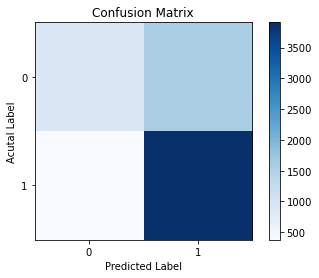


TEST RESULTS:
F1 score: 0.7923028655093077
Recall score: 0.9079578139980825
Precison score: 0.7027829313543599
Confusion Matrix:
[[ 433  801]
 [ 192 1894]]


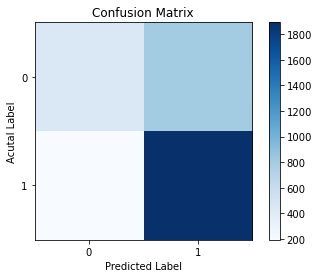

In [52]:
clf_lr = LogisticRegression(max_iter=10000)
model_result(clf_lr, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 0.9963966058351738
Recall score: 1.0
Precision score: 0.9928190873291638
Confusion Matrix:
[[2421   31]
 [   0 4286]]


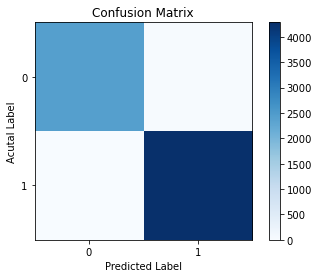


TEST RESULTS:
F1 score: 0.8266726537943422
Recall score: 0.8825503355704698
Precison score: 0.7774493243243243
Confusion Matrix:
[[ 707  527]
 [ 245 1841]]


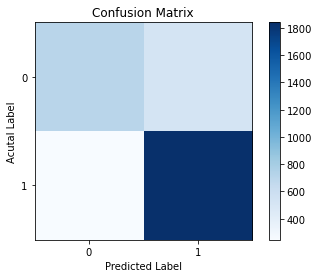

In [57]:
clf_rf = RandomForestClassifier(n_estimators=400, random_state = 123, 
                                 max_features='log2', max_depth=22,
                                 min_samples_split=2)
model_result(clf_rf, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 1.0
Recall score: 1.0
Precision score: 1.0
Confusion Matrix:
[[2452    0]
 [   0 4286]]


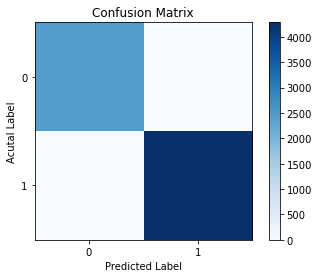


TEST RESULTS:
F1 score: 0.8059838895281932
Recall score: 0.839405560882071
Precison score: 0.7751217352810978
Confusion Matrix:
[[ 726  508]
 [ 335 1751]]


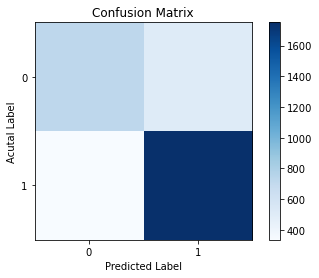

In [54]:
clf_lgbm = LGBMClassifier(random_state=123, n_estimators=500, num_leaves=100)
model_result(clf_lgbm, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 0.8585072147825185
Recall score: 0.9647690153989734
Precision score: 0.7733308397232093
Confusion Matrix:
[[1240 1212]
 [ 151 4135]]


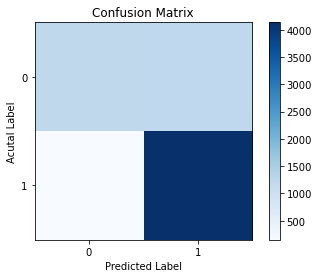


TEST RESULTS:
F1 score: 0.8302286198137172
Recall score: 0.9400767018216682
Precison score: 0.743366186504928
Confusion Matrix:
[[ 557  677]
 [ 125 1961]]


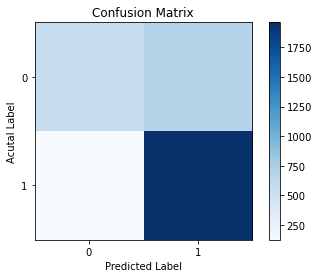

In [29]:
clf_xgb = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate =0.08,n_estimators=308,
                        max_depth=3,min_child_weight=7,
                        gamma=0,subsample=0.7,colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
model_result(clf_xgb, X_train, X_test, y_train, y_test, print_matrix = True)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


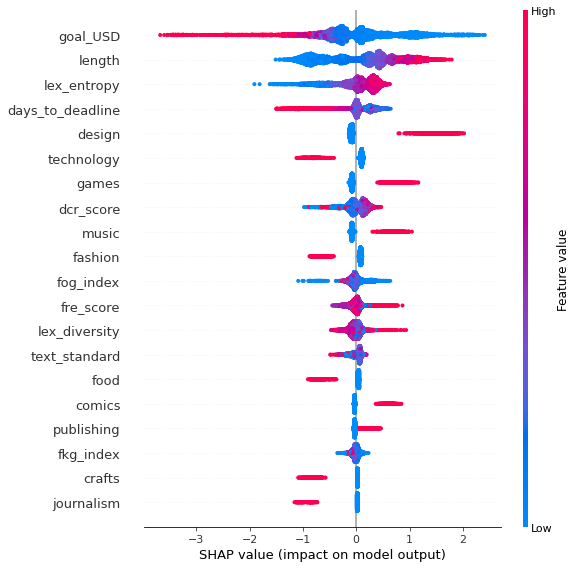

In [30]:
# Feature importance for xgboost model
shap_values = shap.TreeExplainer(clf_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

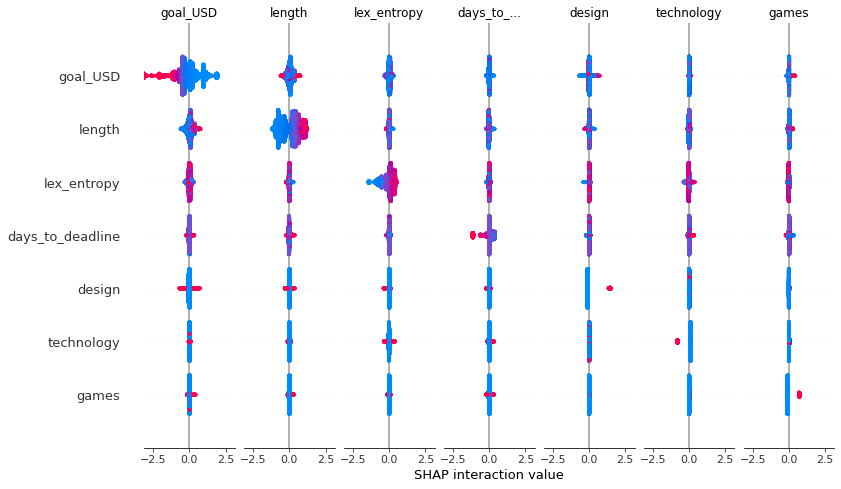

In [31]:
shap_interaction_values = shap.TreeExplainer(clf_xgb).shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

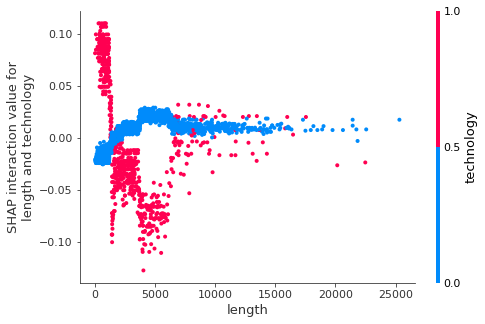

In [32]:
shap.dependence_plot(
    ("length", "technology"),
    shap_interaction_values, X_train,
    display_features=X_train
)

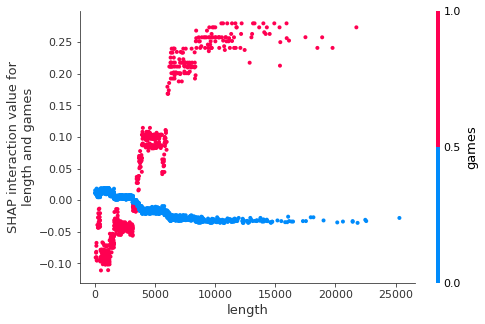

In [33]:
shap.dependence_plot(
    ("length", "games"),
    shap_interaction_values, X_train,
    display_features=X_train
)

## Model results with Doc2Vec word embedding

In [42]:
df_model_d2v = pd.concat([df_model, doctovec_feature_matrix], axis=1)
df_model_d2v

,result,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,...,d2v_90,d2v_91,d2v_92,d2v_93,d2v_94,d2v_95,d2v_96,d2v_97,d2v_98,d2v_99
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.0,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,...,-2.534779,-0.176900,3.095362,0.966774,-3.120079,-0.303085,1.169361,-0.483391,2.350688,3.707440
Komrad - Community | Care | Comradery,0.0,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,...,2.632383,-2.142566,0.729464,1.423505,-1.464109,-1.538552,-0.912207,-0.240881,1.298106,2.163504
Jonesy on the Go Expansion Project,0.0,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,...,-0.802881,0.708144,-0.983804,1.082154,-1.694710,-1.372807,-1.860828,-1.040738,-1.956203,0.925469
NOT WATTS- The restaurant that runs without electricity.,0.0,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,...,-2.177362,-1.551219,1.309394,-0.370621,-2.392838,-1.028023,-3.046495,-1.787845,0.108494,-0.752659
"Healthy, fresh, delicious food delivered to your doorstep!",0.0,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,...,0.955717,0.476158,-1.239118,-0.681135,1.607653,-3.508072,-0.247594,1.770922,0.692778,1.796560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.0,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,...,1.217988,0.447978,2.516444,-1.691508,-2.145148,-0.367670,0.510908,-2.427168,0.960863,0.027788
HelloShrimp - The Real-Life Network for Professionals.,0.0,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,...,0.248322,-1.072751,-0.274889,1.200743,-0.206908,-1.040300,0.157444,0.924319,0.523792,2.449608
Agile Sports Analytics: Team Strategy & Player Execution App,0.0,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,...,-0.281884,-3.956750,0.768241,0.590923,-0.116503,-4.156610,0.562491,-0.118049,-1.354618,3.738206


In [84]:
X = df_model_d2v.iloc[:,1:]
y = df_model_d2v.iloc[:,0]
X

,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,...,d2v_90,d2v_91,d2v_92,d2v_93,d2v_94,d2v_95,d2v_96,d2v_97,d2v_98,d2v_99
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,...,-2.534779,-0.176900,3.095362,0.966774,-3.120079,-0.303085,1.169361,-0.483391,2.350688,3.707440
Komrad - Community | Care | Comradery,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,...,2.632383,-2.142566,0.729464,1.423505,-1.464109,-1.538552,-0.912207,-0.240881,1.298106,2.163504
Jonesy on the Go Expansion Project,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,...,-0.802881,0.708144,-0.983804,1.082154,-1.694710,-1.372807,-1.860828,-1.040738,-1.956203,0.925469
NOT WATTS- The restaurant that runs without electricity.,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,...,-2.177362,-1.551219,1.309394,-0.370621,-2.392838,-1.028023,-3.046495,-1.787845,0.108494,-0.752659
"Healthy, fresh, delicious food delivered to your doorstep!",30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,...,0.955717,0.476158,-1.239118,-0.681135,1.607653,-3.508072,-0.247594,1.770922,0.692778,1.796560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,...,1.217988,0.447978,2.516444,-1.691508,-2.145148,-0.367670,0.510908,-2.427168,0.960863,0.027788
HelloShrimp - The Real-Life Network for Professionals.,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,...,0.248322,-1.072751,-0.274889,1.200743,-0.206908,-1.040300,0.157444,0.924319,0.523792,2.449608
Agile Sports Analytics: Team Strategy & Player Execution App,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,...,-0.281884,-3.956750,0.768241,0.590923,-0.116503,-4.156610,0.562491,-0.118049,-1.354618,3.738206


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


TRAIN RESULTS:
F1 score: 0.8378047422909941
Recall score: 0.8779748016798881
Precision score: 0.801149670002129
Confusion Matrix:
[[1518  934]
 [ 523 3763]]


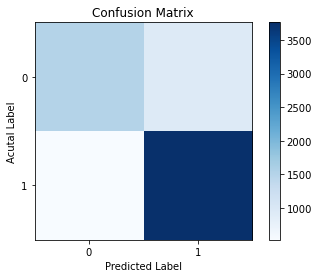


TEST RESULTS:
F1 score: 0.8211678832116788
Recall score: 0.862895493767977
Precison score: 0.783289817232376
Confusion Matrix:
[[ 736  498]
 [ 286 1800]]


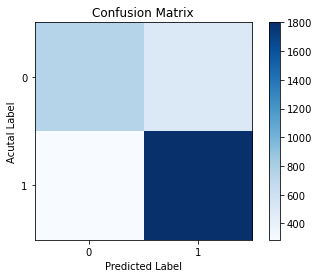

In [86]:
clf_lr = LogisticRegression(max_iter=10000)
model_result(clf_lr, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 0.9996501457725947
Recall score: 1.0
Precision score: 0.9993005362555374
Confusion Matrix:
[[2449    3]
 [   0 4286]]


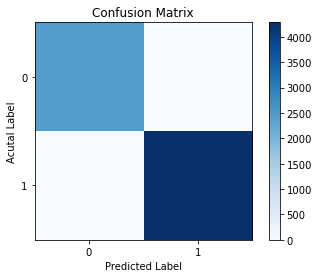


TEST RESULTS:
F1 score: 0.8393357774423118
Recall score: 0.9328859060402684
Precison score: 0.7628381027048217
Confusion Matrix:
[[ 629  605]
 [ 140 1946]]


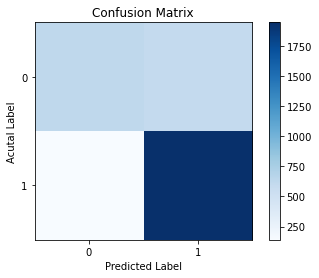

In [87]:
clf_rf = RandomForestClassifier(n_estimators=400, random_state = 123, 
                                 max_features='log2', max_depth=22,
                                 min_samples_split=2)
model_result(clf_rf, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 1.0
Recall score: 1.0
Precision score: 1.0
Confusion Matrix:
[[2452    0]
 [   0 4286]]


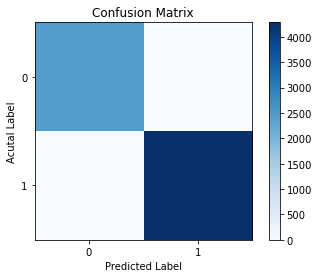


TEST RESULTS:
F1 score: 0.8417233560090703
Recall score: 0.8897411313518696
Precison score: 0.7986230636833046
Confusion Matrix:
[[ 766  468]
 [ 230 1856]]


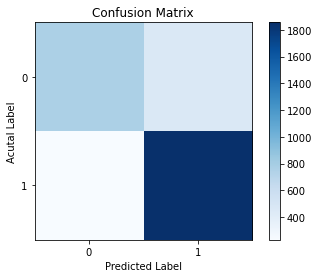

In [89]:
clf_lgbm = LGBMClassifier(random_state=123, n_estimators=500, num_leaves=100)
model_result(clf_lgbm, X_train, X_test, y_train, y_test, print_matrix = True)


TRAIN RESULTS:
F1 score: 0.9965124389676819
Recall score: 1.0
Precision score: 0.9930491195551436
Confusion Matrix:
[[2422   30]
 [   0 4286]]


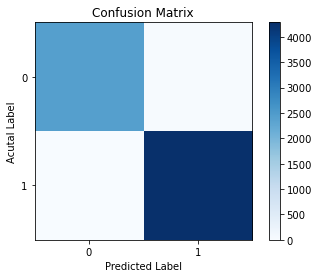


TEST RESULTS:
F1 score: 0.8484312859036677
Recall score: 0.9204218600191755
Precison score: 0.7868852459016393
Confusion Matrix:
[[ 714  520]
 [ 166 1920]]


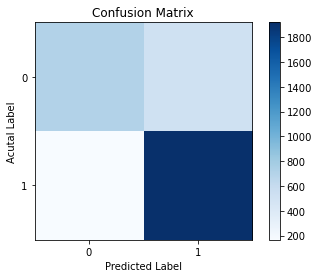

In [88]:
clf_xgb = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate=0.0704525,n_estimators=311,
                        max_depth=7, min_child_weight=7,
                        gamma=0,subsample=0.7, colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
model_result(clf_xgb, X_train, X_test, y_train, y_test, print_matrix = True)

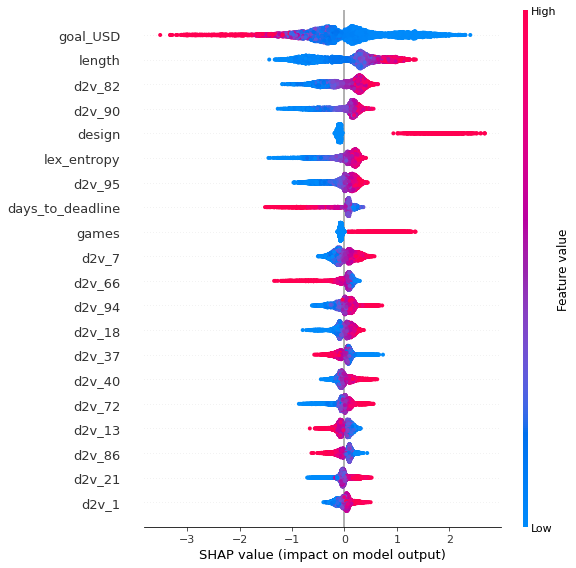

In [94]:
# Feature importance for xgboost model
shap_values = shap.TreeExplainer(clf_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [51]:
# Output model file for later usage
clf_xgb2 = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate=0.0704525,n_estimators=311,
                        max_depth=7, min_child_weight=7,
                        gamma=0,subsample=0.7, colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
clf_xgb2.fit(X_train.values, y_train.values)
filename = 'current_{}.sav'.format(clf_xgb2.__class__.__name__)
pickle.dump(clf_xgb2, open("models/current_XGBClassifier.sav", 'wb'))

In [43]:
# Control Group with only D2W embedding
X = df_model_d2v.iloc[:,26:]
y = df_model_d2v.iloc[:,0]
X

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_90,d2v_91,d2v_92,d2v_93,d2v_94,d2v_95,d2v_96,d2v_97,d2v_98,d2v_99
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.902073,-1.621098,-0.926543,-0.442065,3.647309,3.073392,2.713694,1.409504,-1.439902,3.338297,...,-2.534779,-0.176900,3.095362,0.966774,-3.120079,-0.303085,1.169361,-0.483391,2.350688,3.707440
Komrad - Community | Care | Comradery,-0.622715,-1.302586,3.009642,-0.715653,1.878601,-0.658816,1.018946,-2.607673,2.240116,-0.871471,...,2.632383,-2.142566,0.729464,1.423505,-1.464109,-1.538552,-0.912207,-0.240881,1.298106,2.163504
Jonesy on the Go Expansion Project,1.597855,0.948570,0.732417,1.211082,-0.907459,0.507398,2.808746,-4.871488,2.520253,-3.619430,...,-0.802881,0.708144,-0.983804,1.082154,-1.694710,-1.372807,-1.860828,-1.040738,-1.956203,0.925469
NOT WATTS- The restaurant that runs without electricity.,2.089236,-1.076165,0.335656,2.080410,5.834679,-2.548035,2.564628,-3.015286,4.896177,-0.448215,...,-2.177362,-1.551219,1.309394,-0.370621,-2.392838,-1.028023,-3.046495,-1.787845,0.108494,-0.752659
"Healthy, fresh, delicious food delivered to your doorstep!",0.139801,-0.481757,0.717424,2.636825,1.717019,-2.801194,2.898628,-1.346874,4.640855,0.093653,...,0.955717,0.476158,-1.239118,-0.681135,1.607653,-3.508072,-0.247594,1.770922,0.692778,1.796560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,2.373249,-2.175169,-3.480950,-1.089958,2.257973,1.089916,2.833457,0.630982,4.996249,0.359348,...,1.217988,0.447978,2.516444,-1.691508,-2.145148,-0.367670,0.510908,-2.427168,0.960863,0.027788
HelloShrimp - The Real-Life Network for Professionals.,2.500247,-0.621047,1.809822,-1.064756,2.419722,0.480156,1.175826,-3.166432,2.639724,0.269730,...,0.248322,-1.072751,-0.274889,1.200743,-0.206908,-1.040300,0.157444,0.924319,0.523792,2.449608
Agile Sports Analytics: Team Strategy & Player Execution App,2.438273,-4.146245,-3.236355,0.201279,0.443363,2.191309,-2.176800,-0.710200,1.481071,-0.940426,...,-0.281884,-3.956750,0.768241,0.590923,-0.116503,-4.156610,0.562491,-0.118049,-1.354618,3.738206


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


TRAIN RESULTS:
F1 score: 0.9948932219127206
Recall score: 1.0
Precision score: 0.9898383371824481
Confusion Matrix:
[[2408   44]
 [   0 4286]]


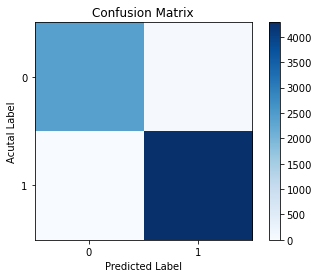


TEST RESULTS:
F1 score: 0.8125943497951261
Recall score: 0.9031639501438159
Precison score: 0.7385339082712662
Confusion Matrix:
[[ 567  667]
 [ 202 1884]]


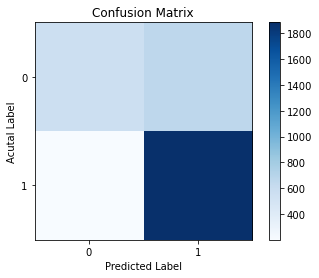

In [45]:
clf_xgb = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate=0.0704525,n_estimators=311,
                        max_depth=7, min_child_weight=7,
                        gamma=0,subsample=0.7, colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
model_result(clf_xgb, X_train, X_test, y_train, y_test, print_matrix = True)

## Model results with tfidf

In [32]:
df_model_tfidf = pd.concat([df_model, tfidf_feature_matrix], axis=1)
df_model_tfidf

,result,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,...,tfidf_également,tfidf_él,tfidf_équipe,tfidf_été,tfidf_être,tfidf_ôøω,tfidf_ôøω äî,tfidf_ôøω äö,tfidf_ôøω ôøω,tfidf_über
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.0,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Komrad - Community | Care | Comradery,0.0,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jonesy on the Go Expansion Project,0.0,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOT WATTS- The restaurant that runs without electricity.,0.0,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Healthy, fresh, delicious food delivered to your doorstep!",0.0,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.0,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HelloShrimp - The Real-Life Network for Professionals.,0.0,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agile Sports Analytics: Team Strategy & Player Execution App,0.0,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X = df_model_tfidf.iloc[:,1:]
y = df_model_tfidf.iloc[:,0]
X

,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,...,tfidf_également,tfidf_él,tfidf_équipe,tfidf_été,tfidf_être,tfidf_ôøω,tfidf_ôøω äî,tfidf_ôøω äö,tfidf_ôøω ôøω,tfidf_über
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Komrad - Community | Care | Comradery,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jonesy on the Go Expansion Project,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOT WATTS- The restaurant that runs without electricity.,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Healthy, fresh, delicious food delivered to your doorstep!",30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HelloShrimp - The Real-Life Network for Professionals.,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agile Sports Analytics: Team Strategy & Player Execution App,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


TRAIN RESULTS:
F1 score: 0.956638655462185
Recall score: 0.9960335977601493
Precision score: 0.9202414313429619
Confusion Matrix:
[[2082  370]
 [  17 4269]]


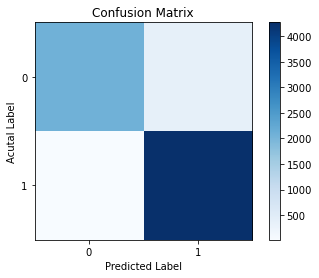


TEST RESULTS:
F1 score: 0.8486439195100612
Recall score: 0.9300095877277086
Precison score: 0.7803700724054706
Confusion Matrix:
[[ 688  546]
 [ 146 1940]]


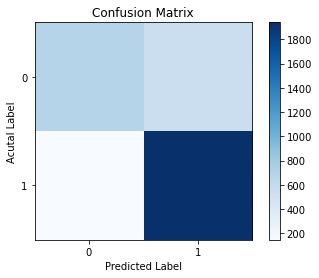

In [35]:
clf_xgb = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate=0.0704525,n_estimators=311,
                        max_depth=7, min_child_weight=7,
                        gamma=0,subsample=0.7, colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
model_result(clf_xgb, X_train, X_test, y_train, y_test, print_matrix = True)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


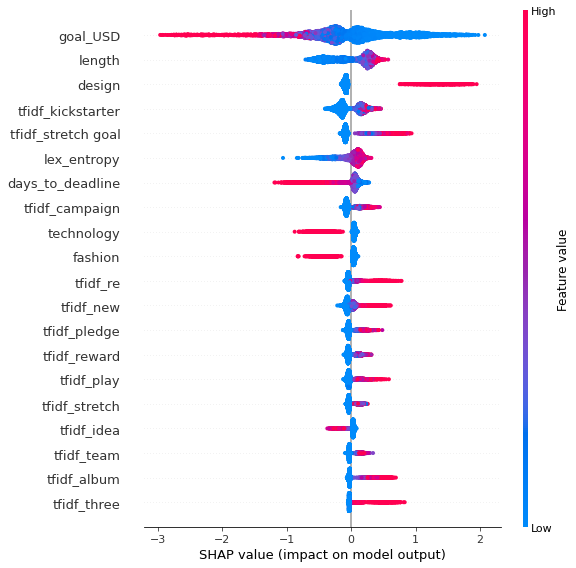

In [36]:
shap_values = shap.TreeExplainer(clf_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model results with LSA (i.e. tfidf+truncatedSVD)

In [50]:
df_model_lsa = pd.concat([df_model, latent_feature_matrix], axis=1)
df_model_lsa

,result,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,...,lsa_490,lsa_491,lsa_492,lsa_493,lsa_494,lsa_495,lsa_496,lsa_497,lsa_498,lsa_499
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,1.0,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,...,0.008707,-0.000015,0.020444,-0.032044,0.009492,0.006946,0.017097,0.007862,0.001836,0.006195
Komrad - Community | Care | Comradery,0.0,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,...,0.003698,0.011323,0.004613,0.018988,-0.000996,-0.022309,0.014191,-0.018315,0.015417,0.014006
Jonesy on the Go Expansion Project,0.0,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,...,-0.014662,-0.006214,0.023571,-0.022080,-0.002437,0.008877,0.025988,0.013376,0.026197,-0.027395
NOT WATTS- The restaurant that runs without electricity.,0.0,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,...,-0.013256,0.016251,-0.003053,-0.009838,0.027717,0.017243,-0.010547,-0.003913,0.001696,0.021014
"Healthy, fresh, delicious food delivered to your doorstep!",0.0,30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,...,-0.010888,-0.004889,0.001796,-0.007878,0.004952,0.008405,-0.037084,0.043393,0.006033,-0.009290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,0.0,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,...,-0.007129,-0.012104,0.032838,-0.015392,0.001882,0.009340,-0.001426,-0.000787,0.004874,0.010307
HelloShrimp - The Real-Life Network for Professionals.,0.0,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,...,0.003730,0.033840,-0.001575,-0.030918,-0.025487,0.016171,-0.013035,-0.023038,-0.005960,-0.019306
Agile Sports Analytics: Team Strategy & Player Execution App,0.0,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,...,-0.019709,-0.010406,-0.004872,-0.000738,-0.001922,-0.002990,-0.005964,-0.016564,0.006439,-0.001524


In [51]:
X = df_model_lsa.iloc[:,1:]
y = df_model_lsa.iloc[:,0]
X

,days_to_deadline,goal_USD,top_ten,length,lex_diversity,lex_entropy,fre_score,fog_index,fkg_index,dcr_score,...,lsa_490,lsa_491,lsa_492,lsa_493,lsa_494,lsa_495,lsa_496,lsa_497,lsa_498,lsa_499
name,,,,,,,,,,,,,,,,,,,,,
4tec: a New 3D Connect 4 Game,30,5781.91765,0,2065,0.595870,4.273365,44.48,21.98,19.9,8.09,...,0.008707,-0.000015,0.020444,-0.032044,0.009492,0.006946,0.017097,0.007862,0.001836,0.006195
Komrad - Community | Care | Comradery,30,77932.17900,1,711,0.763441,4.247977,45.90,13.79,13.1,8.76,...,0.003698,0.011323,0.004613,0.018988,-0.000996,-0.022309,0.014191,-0.018315,0.015417,0.014006
Jonesy on the Go Expansion Project,60,5000.00000,1,1342,0.711957,4.218493,42.14,16.54,14.6,8.79,...,-0.014662,-0.006214,0.023571,-0.022080,-0.002437,0.008877,0.025988,0.013376,0.026197,-0.027395
NOT WATTS- The restaurant that runs without electricity.,30,9687.54885,1,949,0.765152,4.194116,34.12,18.52,17.6,8.75,...,-0.013256,0.016251,-0.003053,-0.009838,0.027717,0.017243,-0.010547,-0.003913,0.001696,0.021014
"Healthy, fresh, delicious food delivered to your doorstep!",30,3162.30532,1,1060,0.779310,4.238193,52.70,11.93,10.5,8.83,...,-0.010888,-0.004889,0.001796,-0.007878,0.004952,0.008405,-0.037084,0.043393,0.006033,-0.009290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HipStick - A Hitting Revolution,60,35000.00000,1,763,0.775701,4.227916,65.66,11.87,9.7,8.10,...,-0.007129,-0.012104,0.032838,-0.015392,0.001882,0.009340,-0.001426,-0.000787,0.004874,0.010307
HelloShrimp - The Real-Life Network for Professionals.,30,11980.49580,1,3987,0.574586,4.236645,52.73,13.58,12.6,7.55,...,0.003730,0.033840,-0.001575,-0.030918,-0.025487,0.016171,-0.013035,-0.023038,-0.005960,-0.019306
Agile Sports Analytics: Team Strategy & Player Execution App,49,6000.00000,1,12767,0.380795,4.201696,48.03,11.91,12.3,6.88,...,-0.019709,-0.010406,-0.004872,-0.000738,-0.001922,-0.002990,-0.005964,-0.016564,0.006439,-0.001524


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


TRAIN RESULTS:
F1 score: 1.0
Recall score: 1.0
Precision score: 1.0
Confusion Matrix:
[[2452    0]
 [   0 4286]]


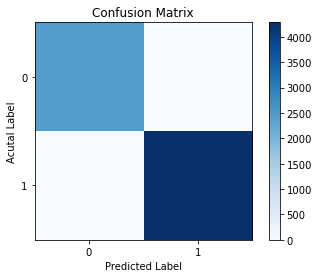


TEST RESULTS:
F1 score: 0.8416428728311004
Recall score: 0.9185043144774688
Precison score: 0.7766518038102959
Confusion Matrix:
[[ 683  551]
 [ 170 1916]]


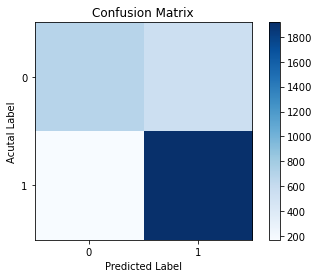

In [53]:
clf_xgb = XGBClassifier(booster='gbtree', nthread = -1, 
                        learning_rate=0.0704525,n_estimators=311,
                        max_depth=7, min_child_weight=7,
                        gamma=0,subsample=0.7, colsample_bytree=0.7,
                        objective= 'binary:logistic',reg_alpha = 1e-05,
                        reg_lambda=1e-05,scale_pos_weight=2,seed=27)
model_result(clf_xgb, X_train, X_test, y_train, y_test, print_matrix = True)